[View in Colaboratory](https://colab.research.google.com/github/liannesr/Lab-3-Machine-Learning/blob/master/Lianne_Sa%C3%A1nchez_Lab_3_Using_Multiple_Numerical_Features_and_Feature_Scaling.ipynb)

#### Copyright 2018 Google LLC.

In [0]:
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

### Imports and Pandas Options
We import the libraries we are using and set some panda options.

In [0]:
import fnmatch
import math

from IPython import display
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn import metrics
import tensorflow as tf
from tensorflow.python.data import Dataset

# This line increasing the amount of logging when there is an error.  You can
# remove it if you want less logging
tf.logging.set_verbosity(tf.logging.ERROR)

# Set the output display to have one digit for decimal places, for display
# readability only and limit it to printing 15 rows.
pd.options.display.float_format = '{:.2f}'.format
pd.options.display.max_rows = 15

### Data Set
As in the last lab we use the [Automobile Data Set](https://archive.ics.uci.edu/ml/datasets/automobile)  from 1985 Ward's Automotive Yearbook that is part of the  [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets) 

### Load and randomizing the data
Load the data using the column names from [Automobile Data Set](https://archive.ics.uci.edu/ml/datasets/automobile). When using SGD (stochastic graident descent) for training it is important that **each batch is a random sample of the data** so that the gradient computed is representative.  While there appears to be no order to this data set, it is always good practice to shuffle the data to be in a random order.


In [0]:
# Provide the names for the columns since the CSV file with the data does
# not have a header row.
cols = ['symboling', 'losses', 'make', 'fuel-type', 'aspiration', 'num-doors',
        'body-style', 'drive-wheels', 'engine-location', 'wheel-base',
        'length', 'width', 'height', 'weight', 'engine-type', 'num-cylinders',
        'engine-size', 'fuel-system', 'bore', 'stroke', 'compression-ratio',
        'horsepower', 'peak-rpm', 'city-mpg', 'highway-mpg', 'price']


# Load in the data from a CSV file that is comma seperated.
car_data = pd.read_csv('https://storage.googleapis.com/ml_universities/cars_dataset/cars_data.csv',
                        sep=',', names=cols, header=None, encoding='latin-1')

# We'll then randomize the data, just to be sure not to get any pathological
# ordering effects that might harm the performance of Stochastic Gradient
# Descent.
car_data = car_data.reindex(np.random.permutation(car_data.index))

### Converting Missing Numerical Values to the Column Mean

As you hopefully found in the last exercise, a good option for replacing missing entries (NaN) is to replace them by the column mean.  We do that here.

In [0]:
car_data['price'] = pd.to_numeric(car_data['price'], errors='coerce')
car_data['horsepower'] = pd.to_numeric(car_data['horsepower'], errors='coerce')
car_data['peak-rpm'] = pd.to_numeric(car_data['peak-rpm'], errors='coerce')
car_data['city-mpg'] = pd.to_numeric(car_data['city-mpg'], errors='coerce')
car_data['highway-mpg'] = pd.to_numeric(car_data['highway-mpg'], errors='coerce')

# Replace nan by the mean storing the solution in the same table (`inplace')
car_data.fillna(car_data.mean(), inplace=True)

### Build Your First Tensor Flow Model

We now build a model to predict `price`, which will be our label (sometimes also called a target) using `horsepower` as our input feature. To train our model, we'll use the [LinearRegressor](https://www.tensorflow.org/api_docs/python/tf/estimator/LinearRegressor) interface provided by the TensorFlow [Estimator](https://www.tensorflow.org/get_started/estimator) API. This API takes care of a lot of the low-level model plumbing, and exposes convenient methods for performing model training, evaluation, and inference.

###Prepare Features
As our learning models get more sophisticated we will want to do some computation on the features and even generate new features from the existing features. We will see examples of this in later labs.  For now this method will just make a copy of a portion of the dataframe.

In [0]:
def prepare_features(dataframe):
  """Prepares the features for provided dataset.

  Args:
    dataframe: A Pandas DataFrame expected to contain data from the
      desired data set.
  Returns:
    A new dataFrame that contains the features to be used for the model.
  """
  processed_features = dataframe.copy()
  return processed_features

###Generate the Training Examples
We simple call `prepare_features` on the `car_data` dataframe.

In [0]:
training_examples = prepare_features(car_data)

###Setting Up the Feature Columns for TensorFlow

In order to import our training data into TensorFlow, we need to specify what type of data each feature contains. There are two main types of data we'll use in this and future exercises:

* **Numerical Data**: Data that is a number (integer or float) and that you want to treat as a number. As we will discuss more later sometimes you might want to treat numerical data (e.g., a postal code) as if it were categorical.

* **Categorical Data**: Data that is textual such as `make` or 'fuel-type`.

In TensorFlow, we indicate a feature's data type using a construct called a **feature column**. Feature columns store only a description of the feature data; they do not contain the feature data itself.

For now, we will just use numerical features.  Later you wll learn how to use categorical data.

In [0]:
NUMERICAL_FEATURES = ["horsepower"]

def construct_feature_columns():
  """Construct the TensorFlow Feature Columns.

  Returns:
    A set of feature columns
  """ 
  return set([tf.feature_column.numeric_column(feature)
              for feature in NUMERICAL_FEATURES])

### Input Function
To import our data into a LinearRegressor, we need to define an input function, which instructs TensorFlow how to preprocess the data, as well as how to batch, shuffle, and repeat it during model training.

First, we'll convert our Pandas feature data into a dictionary of NumPy arrays. We can then use the TensorFlow Dataset API to construct a dataset object from our data, and then break our data into batches of batch_size, to be repeated for the specified number of epochs (num_epochs).

When the default value of num_epochs=None is passed to repeat(), the input data will be repeated indefinitely.

Next, if shuffle is set to True, we'll shuffle the data so that it's passed to the model randomly during training. The buffer_size argument specifies the size of the dataset from which shuffle will randomly sample.

Finally, our input function constructs an iterator for the dataset and returns the next batch of data to the LinearRegressor.

**NOTE:** We'll continue to use this same input function in later exercises. For more
detailed documentation of input functions and the `Dataset` API, see the [TensorFlow Programmer's Guide](https://www.tensorflow.org/programmers_guide/datasets).

In [0]:
def input_fn(features, targets, batch_size=1, shuffle=True, num_epochs=None):
    """Defines a function to preprocess the data, as well as how to batch,
      shuffle, and repeat it during model training..
  
    Args:
      features: pandas DataFrame of features
      targets: pandas DataFrame of targets
      batch_size: Size of batches to be passed to the model
      shuffle: True or False. Whether to shuffle the data.
      num_epochs: Number of epochs for which data should be repeated. None = repeat indefinitely
    Returns:
      Tuple of (features, labels) for next data batch
    """
    
    # Convert pandas data into a dict of np arrays.
    features = {key:np.array(value) for key,value in dict(features).items()}                                           
 
    # Construct a dataset, and configure batching/repeating.
    ds = Dataset.from_tensor_slices((features,targets)) # warning: 2GB limit
    ds = ds.batch(batch_size).repeat(num_epochs)
    
    # Shuffle the data, if specified.
    if shuffle:
      ds = ds.shuffle(10000)
    
    # Return the next batch of data.
    features, labels = ds.make_one_shot_iterator().get_next()
    return features, labels

### Define Input Functions Using the Training Data

We can now use a labda function to create an input function to use when training the model, and one to use when evaluating the model's loss on the training data.

In [0]:
NUMERICAL_FEATURES = ["horsepower"]
CATEGORICAL_FEATURES = []
LABEL = "price"  

# Here we define an input functon that uses the training examples generating
# batches of 10 examples
training_input_fn = lambda: input_fn(
    training_examples[NUMERICAL_FEATURES], training_examples[LABEL], 
    batch_size=10)

# Here we define an input function that will compute the loss over the entire
# training set.
predict_training_input_fn = lambda: input_fn(
    training_examples[NUMERICAL_FEATURES], training_examples[LABEL], 
    num_epochs=1, shuffle=False)

###Configure the LinearRegressor

Next, we'll configure a linear regression model using LinearRegressor. We'll train this model using the `GradientDescentOptimizer`, which implements Mini-Batch Stochastic Gradient Descent (SGD). The `learning_rate` argument controls the size of the gradient step.

**NOTE:** To be safe, we also apply [gradient clipping](https://developers.google.com/machine-learning/glossary/#gradient_clipping) to our optimizer via `clip_gradients_by_norm`. Gradient clipping ensures the magnitude of the gradients do not become too large during training, which can cause gradient descent to fail. 

In [0]:
def define_linear_regression_model(learning_rate):
  """ Defines a linear regression model of one feature to predict the target.
  
  Args:
    learning_rate: A `float`, the learning rate
    batch_size: A non-zero `int`, the batch size.
    
  Returns:
    A linear regressor created with the given parameters
  """
  
  optimizer=tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
  optimizer = tf.contrib.estimator.clip_gradients_by_norm(optimizer, 5.0)
  linear_regressor = tf.estimator.LinearRegressor(
    feature_columns=construct_feature_columns(),
    optimizer=optimizer
  )  
  return linear_regressor

##Train the Model

We now have all the pieces we need to train a model.  In order to generate intermediate losses for the learning curve (and record as we are training), we divide the training into 10 periods.  After each period we compute the loss.  We also store the weight and bias of the model at that time so that we can then visually show how the model evolves in a scatter plot.  You are welcome to modify the number of periods but 10 seems to work out pretty well.

In [0]:
NUMERICAL_FEATURES = ["horsepower"]
CATEGORICAL_FEATURES = []
LABEL = "price"
BATCH_SIZE = 100

# Create regression model using the define_regression_model procedure that we
# defined earlier.
linear_regressor = define_linear_regression_model(learning_rate = 1)

train_input_fn = lambda: input_fn(training_examples[NUMERICAL_FEATURES], 
                                  training_examples[LABEL], 
                                  batch_size=50)
# Train the predictor using 100 steps through the data.
_ = linear_regressor.train(
      input_fn=train_input_fn, steps=100
)

### Evaluate the Model

Let's make predictions on that training data, to see how well our model fit it during training.

**NOTE:** Training error measures how well your model fits the training data, but it **_does not_** measure how well your model **_generalizes to new data_**. In later exercises, you'll explore how to split your data to evaluate your model's ability to generalize.


In [14]:
features = training_examples[NUMERICAL_FEATURES]
targets = training_examples[LABEL]
training_predict_input_fn = lambda: input_fn(
    features, targets, num_epochs=1, shuffle=False)

# Call predict() on the linear_regressor to make predictions.
predictions = linear_regressor.predict(input_fn=training_predict_input_fn)

# Format predictions as a NumPy array, so we can calculate error metrics.
predictions = np.array([item['predictions'][0] for item in predictions])

# Print Mean Squared Error and Root Mean Squared Error.
mean_squared_error = metrics.mean_squared_error(predictions, targets)
root_mean_squared_error = math.sqrt(mean_squared_error)
print("Mean Squared Error (on training data): %0.3f" % mean_squared_error)
print("Root Mean Squared Error (on training data): %0.3f" % root_mean_squared_error)

Mean Squared Error (on training data): 27016431.074
Root Mean Squared Error (on training data): 5197.733


## Computing the Loss
For now we are using root mean squared error (RMSE) for our loss since that is the appropriate loss to use for linear regression.  However, to keep the procedure to train the model very generic, we will use a method compute loss that can be tailored to other types of problems. For this lab, our implementation will be to return the RMSE.


In [0]:
def compute_loss(predictions, targets):
  """ Computes the loss (RMSE) for linear regression.
  
  Args:
    predictions: a list of values predicted by the model being visualized
    targets: a list of the target values being predicted that must be the
             same size as predictions.
    
  Returns:
    The RMSE for the provided predictions and targets
  """      
  return math.sqrt(metrics.mean_squared_error(predictions, targets))

##Learning Curve

Another important tool is a graph often called a **learning curve** that shows the loss being minimized on the y-axis and the training steps (time) on the x-axis.  Looking at the learning curve will help you understand if you have set the `learning_rate` too high or too low, how many `steps` you need to train and other things that we'll explore later.  

Next we define a method to plot the learning curve given a list of training losses that will be recorded at regular intervals during training.

In [0]:
def plot_learning_curve(training_losses):
  """ Plot the learning curve
  
  Args:
    training_loses: a list of losses to plot
  """        
  plt.ylabel('Loss')
  plt.xlabel('Training Steps')
  plt.plot(training_losses)

###Learning Using Multiple Numerical Features and Featuring Scaling

We now being to explore some of the issues that can occur when using multiple numerical features, and how we can adress them.  Let's start by plotting a histogram of price, highway-mpg and city-mpg to help understand the data we are using to train our model to predict city-mpg.

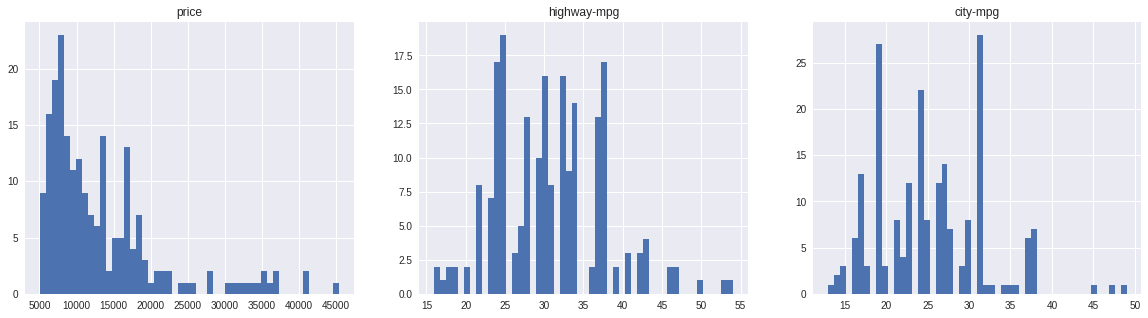

In [17]:
plt.figure(figsize=(20, 5))
plt.subplot(1, 3, 1)
plt.title("price")
histogram = car_data["price"].hist(bins=50)

plt.subplot(1, 3, 2)
plt.title("highway-mpg")
histogram = car_data["highway-mpg"].hist(bins=50)


plt.subplot(1, 3, 3)
plt.title("city-mpg")
histogram = car_data["city-mpg"].hist(bins=50)

###Visualizing Our Model Via a Calibration Plot

When we just use a single input feature, we can visualize the data and the learned model very well with **scater plot**.  In order to help understand higher-dimensional models, a **calibration plot** is very useful. A calibration plot is similar to a scatter plot of the data except this can be used for any linear model since it just plots the target with respec to the predictions. Observe that a model with an RMSE of 0 would have all points on the line target = prediction.  For points that are under the line, we are overpredicting and points over the line we are underpredicting.  This method shows the line target = prediction to help visualize how well the model is doing.

Observe that unlike in the scatter plot where the points are fixed and the model (as viewed as a line changes), in the callibration plot the x-coordinate of the points change as the model is trained.

In [0]:
def calibration_plot(predictions, targets):
  """ Creates a calibration plot.
  
  Args:
    predictions: a list of values predicted by the model being visualized
    targets: a list of the target values being predicted that must be the
             same size as predictions.
  """  
  calibration_data = pd.DataFrame()
  calibration_data["predictions"] = pd.Series(predictions)
  calibration_data["targets"] = pd.Series(targets)
  calibration_data.describe()
  min_val = calibration_data["predictions"].min()
  max_val = calibration_data["predictions"].max()
  plt.ylabel("target")
  plt.xlabel("prediction")
  plt.scatter(predictions, targets, color='black')
  plt.plot([min_val, max_val], [min_val, max_val])

Notice that the model we have trained so far is not very good and you can see this when looking at the calibration plot. Your first task will be to improve this model.  

## Exercise: Studying a Calibration Plot (1 point)

The code box below generates a calibration plot for this model.  How does it look compared to the scatter plot?  Explain what you are seeing and why it is this way.

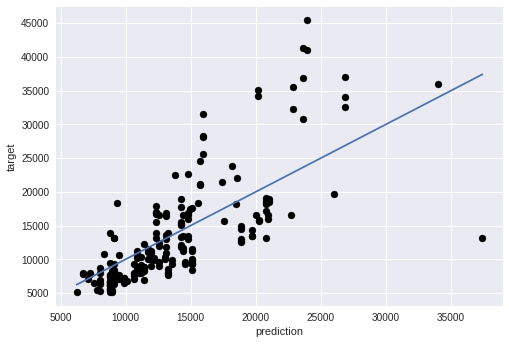

In [19]:
# Call predict() on the linear_regressor to make predictions.
training_predict_input_fn = lambda: input_fn(
    training_examples[NUMERICAL_FEATURES], 
    training_examples[LABEL], num_epochs=1, shuffle=False)
predictions = linear_regressor.predict(input_fn=training_predict_input_fn)
predictions = np.array([item['predictions'][0] for item in predictions])
calibration_plot(predictions, car_data[LABEL].values)



In [20]:
"""
Explain the relationship you are seeing between the scatter plot and calibration
plot, and why this is the case.

1. In this calibration plot I am seeing that both axis are the labels of the data
one is the actual correct value and the other one is the prediction. I am viewing 
how well are my predictions vs in the scatter plot I get to see how well the model
is fitting the data. In the calibration plot we can observe if we actually 
underpredicted a value (if its on the upper part) and if we overpredictted a value
(if its on the lower part). The calibration plot gives you the opportunity to
view if your model is predicting well and this is because it compares how 
far away is our prediction from the actual value. The scatter plot will only help
us visualize one dimension linear models but with the calibration plot
we can use it for 3D and over because it is only comparing the labels as mentioned 
before. 

In this particular plot I could observe that the model best predicts for car 
prices that range between 5,000 - 15,000 because the data points are closer
to the line of prediction. But the model does not predict well for items that 
range from 15,000 up we know this because of the distance between the data
points and the line. Thus, making it not the optimal or best model to 
predict our data.


"""

'\nExplain the relationship you are seeing between the scatter plot and calibration\nplot, and why this is the case.\n\nTYPE YOUR ANSWER IN THIS COMMENT\n\n\nI DO NOT UNDERSTAND DE DIFFERENCE \n\n\n'

### Studying Our Data

It is always valuable to understand you data.  Let's look at a histogram showing the values of `price`, `highway-mpg`, and `city-mpg`

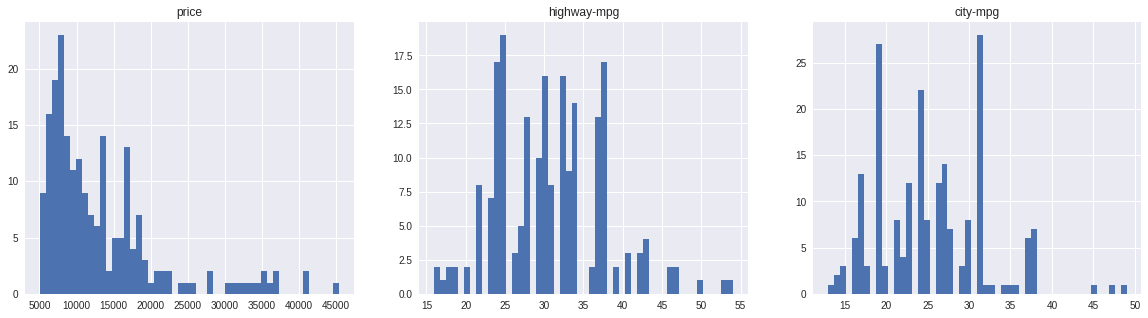

In [21]:
plt.figure(figsize=(20, 5))
plt.subplot(1, 3, 1)
plt.title("price")
histogram = car_data["price"].hist(bins=50)

plt.subplot(1, 3, 2)
plt.title("highway-mpg")
histogram = car_data["highway-mpg"].hist(bins=50)


plt.subplot(1, 3, 3)
plt.title("city-mpg")
histogram = car_data["city-mpg"].hist(bins=50)

##Exercise: Train a Model Using Multiple Features (2 points)

The focus on this section is learning some of the issues that arise,  and how to address them when you train a model with multiple features.  The first task is to train a model to predict `city-mpg` from `highway-mpg` and `price` without using any feature processing.  Remember what you learned in the last lab about how to find a good learning rate and numer of steps to train.

### Function to train a model

We provide a method that trains a linear model using any set of features that breaks the learning up into 10 periods, and shows the learning curve and calibration plot after training the model.

In [0]:
# Function to train any linear model using a calibration plot to help visualize
# the final model

def train_model(linear_regressor, features, labels, steps, batch_size):
  """Trains a linear regression model.
  
  Args:
    linear_regressor: The regressor to train
    features: The input features to use
    label: the labels
    steps: A non-zero `int`, the total number of training steps.
    batch_size: A non-zero `int`, the batch size.
    
  Returns:
    The trained regressor
  """
  # In order to see how the model evolves as we train it, we will divide the
  # steps into periods and show the model after each period.
  periods = 10
  steps_per_period = steps / periods
  
  # Set up the training_input_fn and predict_training_input_fn
  training_input_fn = lambda: input_fn(features, labels, batch_size=batch_size)
  predict_training_input_fn = lambda: input_fn(features, labels, num_epochs=1,
                                               shuffle=False)
  
  # Train the model, but do so inside a loop so that we can periodically assess
  # loss metrics.  We store the training losses to generate the training curve
  print("Training model...")
  training_losses = []

  for period in range (0, periods):
    # Call fit to train the regressor for steps_per_period steps
    _ = linear_regressor.train(input_fn=training_input_fn, steps=steps_per_period)

    # Use the predict method to compute the predictions from the current model
    predictions = linear_regressor.predict(input_fn=predict_training_input_fn)
    predictions = np.array([item['predictions'][0] for item in predictions])
   
    # Compute the loss between the predictions and the correct labels, append
    # the loss to the list of losses used to generate the learning curve after
    # training is complete and print the current loss
    loss = compute_loss(predictions, labels)
    training_losses.append(loss) 
    print("  Loss after period %02d : %0.3f" % (period, loss))
      
  # Now that training is done print the final loss    
  print("Final Loss (RMSE) on the training data: %0.3f" % loss) 
  
  # Generate a figure with the learning curve on the left and either a scatter
  # plot or calibration plot (when more than 2 input features) on the right
  plt.figure(figsize=(10, 5))
  plt.subplot(1, 2, 1)
  plt.title("Learning Curve (RMSE vs time)")
  plot_learning_curve(training_losses)
  plt.subplot(1, 2, 2)
  plt.tight_layout(pad=1.1, w_pad=3.0, h_pad=3.0)
  plt.title("Calibration Plot")
  calibration_plot(predictions, labels)
   
  return linear_regressor

Training model...
  Loss after period 00 : 25.443
  Loss after period 01 : 24.960
  Loss after period 02 : 24.573
  Loss after period 03 : 24.266
  Loss after period 04 : 24.008
  Loss after period 05 : 23.798
  Loss after period 06 : 23.642
  Loss after period 07 : 23.506
  Loss after period 08 : 23.405
  Loss after period 09 : 23.322
Final Loss (RMSE) on the training data: 23.322


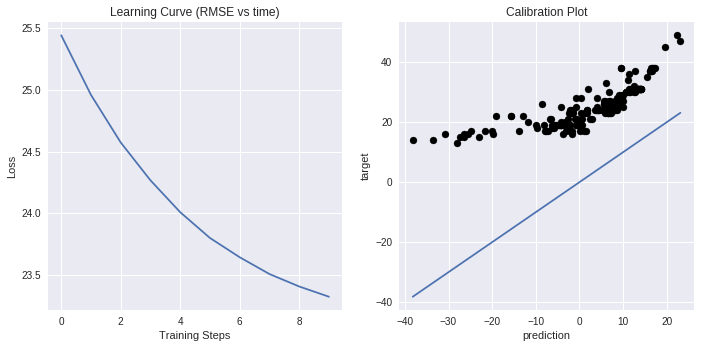

In [23]:
NUMERICAL_FEATURES = ["price", "highway-mpg"]
CATEGORICAL_FEATURES = []
LABEL = "city-mpg"

# Adjust these hyperparameters
LEARNING_RATE = .00519
STEPS = 60000
BATCH_SIZE = 50

linear_regressor = define_linear_regression_model(learning_rate = LEARNING_RATE)
linear_regressor = train_model(linear_regressor,
                               training_examples[NUMERICAL_FEATURES],
                               training_examples[LABEL],
                               batch_size=BATCH_SIZE, steps=STEPS)

Let's look at the model weights learned.

In [24]:
print("weight for price:", linear_regressor.get_variable_value(
    "linear/linear_model/price/weights")[0])
print("weight for highway-mpg:", linear_regressor.get_variable_value(
    "linear/linear_model/highway-mpg/weights")[0])
print("bias:",  linear_regressor.get_variable_value("linear/linear_model/bias_weights"))

weight for price: [-0.00103094]
weight for highway-mpg: [0.53658396]
bias: [0.01279595]


### Think about these questions 

* Look at the weight for the two variables.  Do they match what you'd expect to see?
* Given that `highway-mpg` is well correlated with `city-mpg`, what is it you see in the histograms that might explain why it was hard to train the model?
* For linear regression it is important that all of the features are roughly in the same range so that a priori they are treated as equally important.  How does the range of the price compare to the highway mpg, and what effect might this have when training the model?


In [25]:
"""
TYPE YOUR ANSWERS TO THE QUESTIONS HERE
1. No, they do not match what I would expect to see as a prediction line. My
  hypothesis is that I would assume that since the highway-mpg and city-mpg
  have a better correlation the highway-mpg would have a higher weight in the model.
2.  I can observe that the histogram of price has bigger values. But that the 
  city-mpg and highway-mpg are pretty similitar in terms of scale. For 
  example the highway-mpg and city-mpg only goes to up to 55 versus the price 
  which goes up to 45,000. When putting up into the equation y' = w1x1 + w2x2 + b 
  the number of price will dominate in the equation and the model will forget 
  or disregard the most important feature which is higway-mpg.
3. As mentioned before the price range goes up to 45,000 versus the highway-mpg
  goes up to 45 thus making the price dominate in the equation ignoring the 
  highway-mpg. And while training it will basically not take into consideration
  the highway-mpg.
"""

"\nTYPE YOUR ANSWERS TO THE QUESTIONS HERE\n1. No, they do not match what I would expect to see as a prediction line. My\n  hypothesis is that I noticed the weight of the price for the data is negative \n  when the target data is in the positive axis. By having one of the weights \n  negative we are subtracting to the model.\n2.  I can observe that the histogram of price has bigger values. For \n  example the highway-mpg only goes to up to 55 versus the price which goes up\n  to 45,000. When putting up into the equation y' = w1x1 + w2x2 + b the number \n  of price will dominate in the equation and the model will forget or disregard\n  the most important feature which is higway-mpg.\n3. As mentioned before the price range goes up to 45,000 versus the highway-mpg\n  goes up to 45 thus making the price dominate in the equation ignoring the \n  highway-mpg. And while training it will basically not take into consideration\n  the highway-mpg.\n"

## Exercise: Write a Linear Scaling Function (1 point)

There are two characteristics we'd like of numerical features when used together to train a linear model
* The range of the features is roughly the same
* To the extent possible the histogram of the features kind of resembles a bell curve.  Sometimes the data will fit this very well and other times it won't.

As you've already seen in the code, you can take a Pandas column (e.g. `car_data['price']`) and find the min value with `car_data['price'].min()` and likewise find the max with `car_data['price'].max()`. Note that you can use a lambda function to apply `f(x)` to all entries `x` in a Pandas column `feature` using.
```
   feature.apply(lambda x: f(x))
```

To provide an example of feature transformation, we have provided an implementation for log scaling.  Note that we take the log of x+1 for column value of x so that we are always taking the log of a number greater than 0 since log 0 is not defined. In this data all values are at least 0, so log(x+1) is well defined.

You are to complete the implementation of `linear_scale`, in which you simply stretch/compress and shift the features linearly to fall into the interval [0,1]. The minimum value that occurs will map to 0, the maximum value that occurs will map to 1, (min + max)/2 will map to 0.5, and so on.  You will need to make sure that your output from `linear_scale` is a real number (versus an integer). Be sure to test your function on some examples.  For example if the input series originally had values going from 10 to 20, then after applying linear scale 10 should map to 0, 11 should map to 1, 12 should map to 2, ... and so on with 20 mapping to 1.

In [0]:
# Perform log scaling
def log_scale(series):
  return series.apply(lambda x:math.log(x+1.0))

# Linearly rescales to the range [0, 1]
# You need to write this function.  Right now it just returns the same series.
def linear_scale(series):
  # add any additional lines of code needed
  return series.apply(lambda x: (x-series.min())/(series.max()-series.min()))

**Test your scaling procedure** with the following code block that applies these two scaling methods to `price` and `highway-mpg` and then draws a histogram for each.

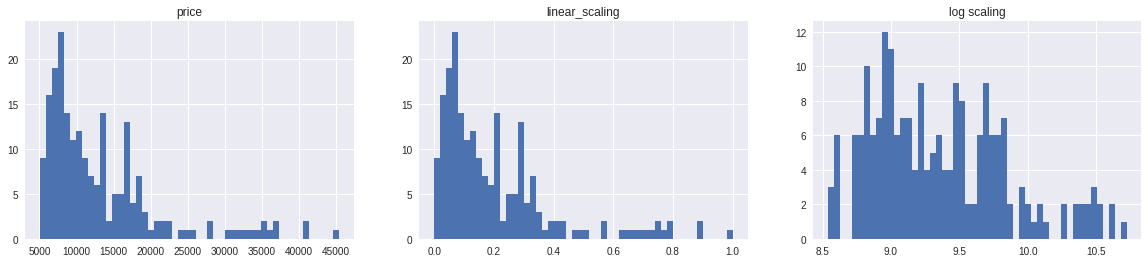

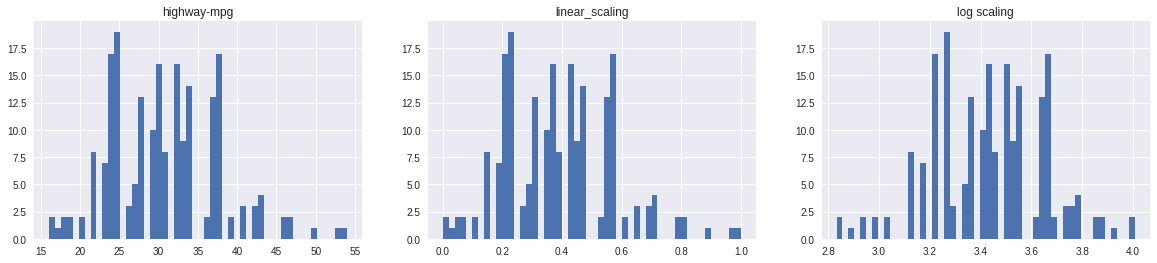

In [46]:
def draw_histograms(feature_name):
  plt.figure(figsize=(20, 4))
  plt.subplot(1, 3, 1)
  plt.title(feature_name)
  histogram = car_data[feature_name].hist(bins=50)

  plt.subplot(1, 3, 2)
  plt.title("linear_scaling")
  scaled_features = pd.DataFrame()
  scaled_features[feature_name] = linear_scale(car_data[feature_name])
  histogram = scaled_features[feature_name].hist(bins=50)
  
  plt.subplot(1, 3, 3)
  plt.title("log scaling")
  log_normalized_features = pd.DataFrame()
  log_normalized_features[feature_name] = log_scale(car_data[feature_name])
  histogram = log_normalized_features[feature_name].hist(bins=50)
  
draw_histograms("price")
draw_histograms("highway-mpg")

##Exercise: Training the Model Using the Transformed Features (2 points)

Modify `prepare_features` to apply linear scaling to `price` and `highway-mpg` and then train the best model you can. **Do not modify the target feature so that the RMSE can be compared to the model you trained in Task 2 and also you want your predictions to be in the correct range**.

NOTE: It is possible that if your learning rate is too high you will converge to a solution that is not optimal since you are overshotting and then undershooting the best feature weights as you get close to the optimal solution.  So when looking at the scatter plot, if you converge to a model that is not good, try a slightly smaller learning rate.



In [0]:
def prepare_features(dataframe,feature_names=[]):
  """Prepares the features for provided dataset.

  Args:
    dataframe: A Pandas DataFrame expected to contain data from the
      desired data set.
    feature_names: The names of the features to linearize
  Returns:
    A new dataFrame that contains the features to be used for the model.
  """
  processed_features = dataframe.copy()
  for feature in feature_names:
    processed_features[feature] = linear_scale(processed_features[feature])


  """
  At first I performed just hardcoding the features to be linearized
  But its better if I modify the methods arguments so the user can input 
  several data as parameter and implementation would not have to change in case
  of needing to add another feature to perform linear scaling on.
  processed_features["price"] = linear_scale(processed_features["price"])
  processed_features["highway-mpg"] = linear_scale(processed_features["highway-mpg"])
"""
  # Fill in what you want to do here.
  
  return processed_features

Let's look at the histograms after the feature transformations to ensure it looks as expected.

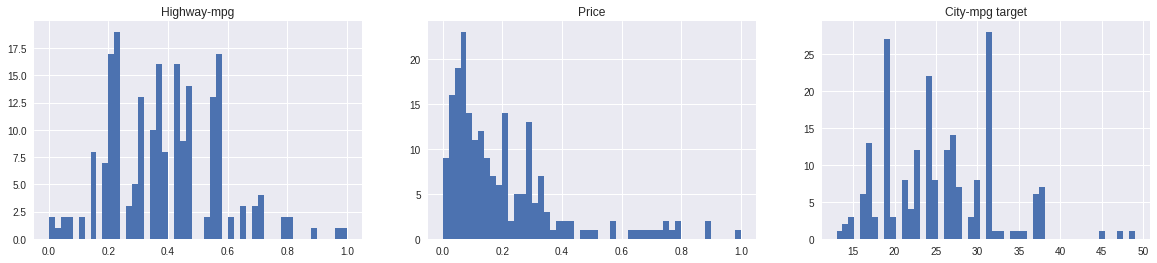

In [62]:
"""
  After preparing the training examples by using the linear scaling 
  method for price and highway  
"""

training_examples = prepare_features(car_data,["highway-mpg","price"])
plt.figure(figsize=(20, 4))
plt.subplot(1,3,1)
plt.title("Highway-mpg")
histogram = training_examples["highway-mpg"].hist(bins=50)
plt.subplot(1,3,2)
plt.title("Price")
histogram = training_examples["price"].hist(bins=50)

"""
  This is the target. I just wanted to check and verify that I did not changed its 
  properties.
"""
plt.subplot(1,3,3)
plt.title("City-mpg target")
histogram = training_examples["city-mpg"].hist(bins=50)

Now let's train a model.  You should find that you can get a lot better model after the feature transformations have been applied.

Training model...
  Loss after period 00 : 15.543
  Loss after period 01 : 6.409
  Loss after period 02 : 3.650
  Loss after period 03 : 2.329
  Loss after period 04 : 1.809
  Loss after period 05 : 1.619
  Loss after period 06 : 1.566
  Loss after period 07 : 1.555
  Loss after period 08 : 1.555
  Loss after period 09 : 1.553
Final Loss (RMSE) on the training data: 1.553


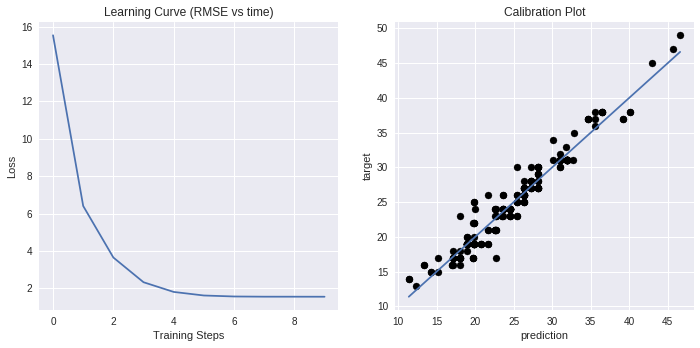

In [65]:
NUMERICAL_FEATURES = ["price", "highway-mpg"]
CATEGORICAL_FEATURES = []
LABEL = "city-mpg"

# Fill in the rest of the code block to train a model and view the model
# weights.
# Adjust these hyperparameters
LEARNING_RATE = .002
STEPS = 10000
BATCH_SIZE = 50

linear_regressor = define_linear_regression_model(learning_rate = LEARNING_RATE)
linear_regressor = train_model(linear_regressor,
                               training_examples[NUMERICAL_FEATURES],
                               training_examples[LABEL],
                               batch_size=BATCH_SIZE, steps=STEPS)

In [64]:
print("weight for price:", linear_regressor.get_variable_value(
    "linear/linear_model/price/weights")[0])
print("weight for highway-mpg:", linear_regressor.get_variable_value(
    "linear/linear_model/highway-mpg/weights")[0])
print("bias:",  linear_regressor.get_variable_value("linear/linear_model/bias_weights"))

weight for price: [-5.344438]
weight for highway-mpg: [28.403864]
bias: [15.290324]


1. RMSE in Task 2 : 23.322
2. RMSE in Task 4 : 1.553

Conclusion: 
There is much less squared mean error in the task when the data was scaled linearly. I conclude that the input data should be in similar ranges. Because 
if very different ranges exist you will have predictions that are not to good for your actual target values. You can use log scaling, linear scaling, clipping or z-score.


You are welcome to also explore using other feature transformations such as log scaling or linear scaling applied after log scaling.  However, for this simple problem, linear scaling is sufficient.